<a href="https://colab.research.google.com/github/nxn-matrix/acn5314/blob/master/DenseNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020
##### Project: Vehicle Identification using Transfer Learning with pretrained CNNs
##### Class: UTD ACN 5314 Spring 2020
##### Authors: Dinakar, Meenakshi, Thilip, Vivek

 

##### 1. Import required packages and make sure to use the latest Tensorflow version

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#import seaborn as sns

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.2.0-rc3


##### 2. Download Dataset

In [2]:
tfds.disable_progress_bar()
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cars196',
    split=['train[:100%]+test[:60%]', 'test[60%:80%]', 'test[80%:100%]'],
    with_info=True,
    as_supervised=True,
)
print(raw_train)
print(raw_validation)
print(raw_test)

#sns.pairplot(raw_train)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompletePPV0M7/cars196-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompletePPV0M7/cars196-test.tfrecord
Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


##### 3. Show first 3 images and labels from training set for sanity check

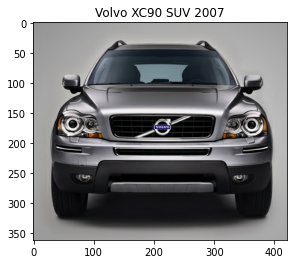

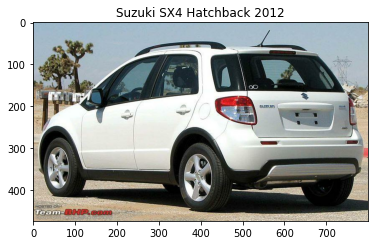

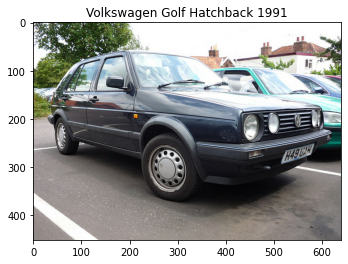

In [3]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

##### 4. Function to preprocess the dataset to be compatible with the model


In [0]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1

  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

##### 5. Function to prepare training set with data augmentation

In [0]:
def aug_format_example(image, label):

  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.image.random_flip_left_right(image) # random horizontal flip
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  # random shift
  pad_left  = random.randrange(10,50);
  pad_right = random.randrange(10,50);
  pad_top   = random.randrange(10,50);
  pad_bottom = random.randrange(10,50);
  image = tf.image.pad_to_bounding_box(image, pad_top, pad_left, IMG_SIZE + pad_bottom + pad_top, IMG_SIZE + pad_left + pad_right)
  image = tf.image.crop_to_bounding_box(image, pad_bottom, pad_right, IMG_SIZE, IMG_SIZE)

  return image, label


##### 6. Get the final training, validation and test sets. Also, get the data augmented training set.

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
aug_train = raw_train.map(aug_format_example)

##### 7. Show first 3 images of preprocessed training set images

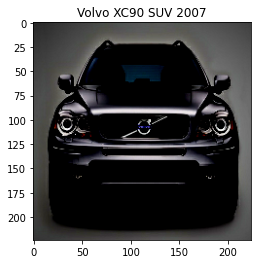

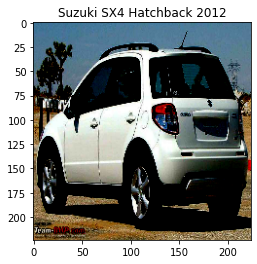

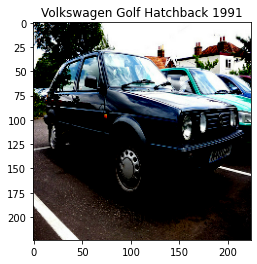

In [7]:
for image, label in train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

##### 8. Show first 3 images of data augmented training set images

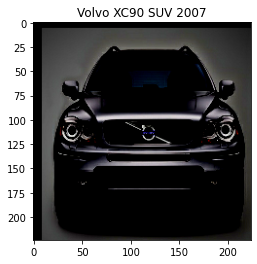

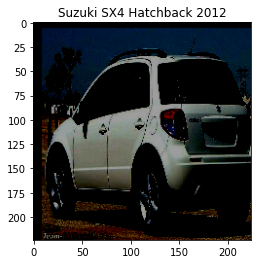

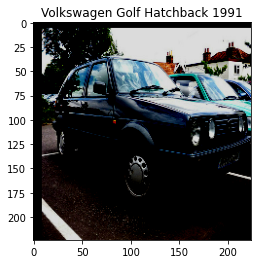

In [8]:
for image, label in aug_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

##### 9. Create batches to train/validate/test and inspect the batch tensor shape

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
aug_train_batches = aug_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

##### 10. create base model and set it as non-trainable

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
base_model.summary()

74842112/74836368 [==============================] - 1s 0us/step
(32, 7, 7, 1920)
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______

##### 11. Add classification head and compile the new model

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(196)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0002
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

(32, 1920)
(32, 196)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               376516    
Total params: 18,698,500
Trainable params: 376,516
Non-trainable params: 18,321,984
_________________________________________________________________


##### 12. Train the model.

In [12]:
len(model.trainable_variables)
initial_epochs   = 40
validation_steps = 50

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches
                    )

50/50 [==============================] - 5s 103ms/step - loss: 5.6188 - accuracy: 0.0056
initial loss: 5.62
initial accuracy: 0.01
Epoch 1/40
406/406 [==============================] - 77s 189ms/step - loss: 4.0735 - accuracy: 0.1602 - val_loss: 3.1202 - val_accuracy: 0.3078
Epoch 2/40
406/406 [==============================] - 77s 190ms/step - loss: 2.4271 - accuracy: 0.4638 - val_loss: 2.4320 - val_accuracy: 0.4303
Epoch 3/40
406/406 [==============================] - 77s 190ms/step - loss: 1.7430 - accuracy: 0.6283 - val_loss: 2.1055 - val_accuracy: 0.4975
Epoch 4/40
406/406 [==============================] - 77s 191ms/step - loss: 1.3303 - accuracy: 0.7285 - val_loss: 1.9266 - val_accuracy: 0.5317
Epoch 5/40
406/406 [==============================] - 77s 190ms/step - loss: 1.0487 - accuracy: 0.7959 - val_loss: 1.8010 - val_accuracy: 0.5591
Epoch 6/40
406/406 [==============================] - 77s 189ms/step - loss: 0.8532 - accuracy: 0.8462 - val_loss: 1.7212 - val_accuracy: 0.5752

##### 13. Test the model

In [13]:
test_steps = validation_steps
test_loss, test_acc = model.evaluate(test_batches, steps = test_steps)

50/50 [==============================] - 5s 96ms/step - loss: 1.8566 - accuracy: 0.5919


##### 14. Plot learning curves

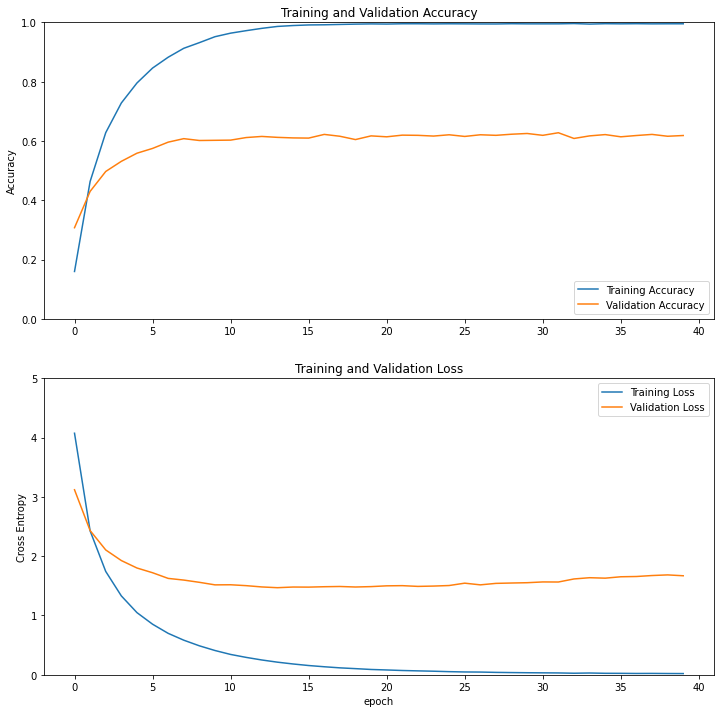

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### 15. Get the number of layers in base model

In [15]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))



Number of layers in the base model:  707


##### 16. Fine-tune the model

In [16]:
fine_tune_at = 700
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #sparse = decimal encoding
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               376516    
Total params: 18,698,500
Trainable params: 659,140
Non-trainable params: 18,039,360
_________________________________________________________________


8

##### 17. Continue to train the model after fine-tuning.

In [17]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)


Epoch 40/80
406/406 [==============================] - 80s 196ms/step - loss: 0.6190 - accuracy: 0.8251 - val_loss: 3.1506 - val_accuracy: 0.4720
Epoch 41/80
406/406 [==============================] - 78s 192ms/step - loss: 0.2162 - accuracy: 0.9311 - val_loss: 2.7348 - val_accuracy: 0.5155
Epoch 42/80
406/406 [==============================] - 78s 191ms/step - loss: 0.0911 - accuracy: 0.9763 - val_loss: 2.4825 - val_accuracy: 0.5466
Epoch 43/80
406/406 [==============================] - 77s 190ms/step - loss: 0.0520 - accuracy: 0.9887 - val_loss: 2.3480 - val_accuracy: 0.5616
Epoch 44/80
406/406 [==============================] - 78s 191ms/step - loss: 0.0323 - accuracy: 0.9948 - val_loss: 2.2686 - val_accuracy: 0.5703
Epoch 45/80
406/406 [==============================] - 78s 191ms/step - loss: 0.0257 - accuracy: 0.9959 - val_loss: 2.2152 - val_accuracy: 0.5746
Epoch 46/80
406/406 [==============================] - 77s 189ms/step - loss: 0.0218 - accuracy: 0.9961 - val_loss: 2.1833 -

##### 18. Test the model after fine-tuning

In [18]:
test_loss, test_acc = model.evaluate(test_batches, steps = test_steps)

50/50 [==============================] - 5s 96ms/step - loss: 2.2066 - accuracy: 0.5813


##### 19. Plot the learning curves including fine-tuning case

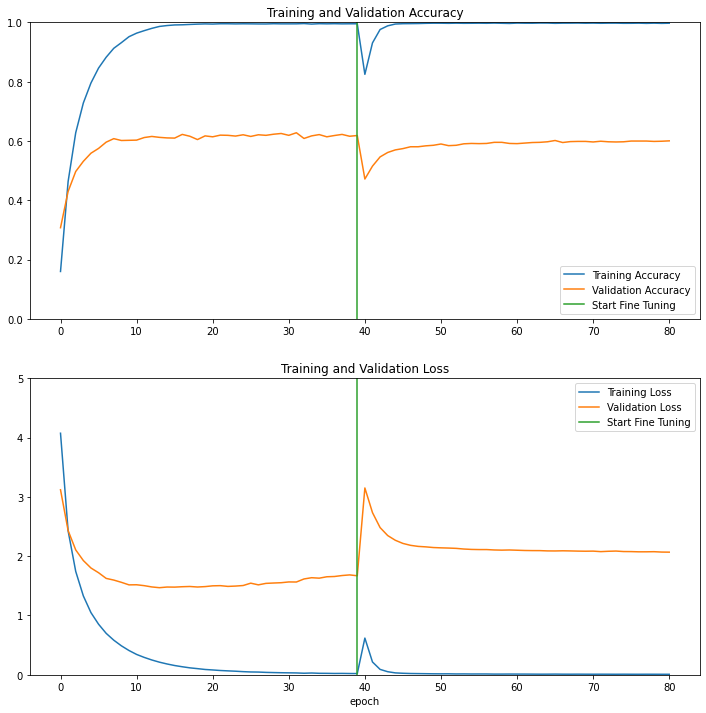

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### 20. Continue training the model with data augmented training set

In [20]:
aug_epochs = 40
final_epochs =  total_epochs + aug_epochs

history_aug = model.fit(aug_train_batches,
                         epochs=final_epochs,
                         initial_epoch =  history_fine.epoch[-1],
                         validation_data=validation_batches)


Epoch 80/120
406/406 [==============================] - 103s 253ms/step - loss: 0.2088 - accuracy: 0.9328 - val_loss: 2.1160 - val_accuracy: 0.5995
Epoch 81/120
406/406 [==============================] - 103s 253ms/step - loss: 0.2019 - accuracy: 0.9380 - val_loss: 2.1095 - val_accuracy: 0.6032
Epoch 82/120
406/406 [==============================] - 102s 252ms/step - loss: 0.1865 - accuracy: 0.9430 - val_loss: 2.1055 - val_accuracy: 0.6070
Epoch 83/120
406/406 [==============================] - 101s 249ms/step - loss: 0.1821 - accuracy: 0.9451 - val_loss: 2.1053 - val_accuracy: 0.6070
Epoch 84/120
406/406 [==============================] - 102s 252ms/step - loss: 0.1797 - accuracy: 0.9473 - val_loss: 2.1007 - val_accuracy: 0.6076
Epoch 85/120
406/406 [==============================] - 101s 249ms/step - loss: 0.1776 - accuracy: 0.9465 - val_loss: 2.0996 - val_accuracy: 0.6076
Epoch 86/120
406/406 [==============================] - 102s 251ms/step - loss: 0.1657 - accuracy: 0.9511 - val_

##### 21. Test the model after data augmentation

In [21]:
test_loss, test_acc = model.evaluate(test_batches, steps = test_steps)

50/50 [==============================] - 5s 93ms/step - loss: 2.1855 - accuracy: 0.5969


##### 22. Plot the learning curves with data augmentation

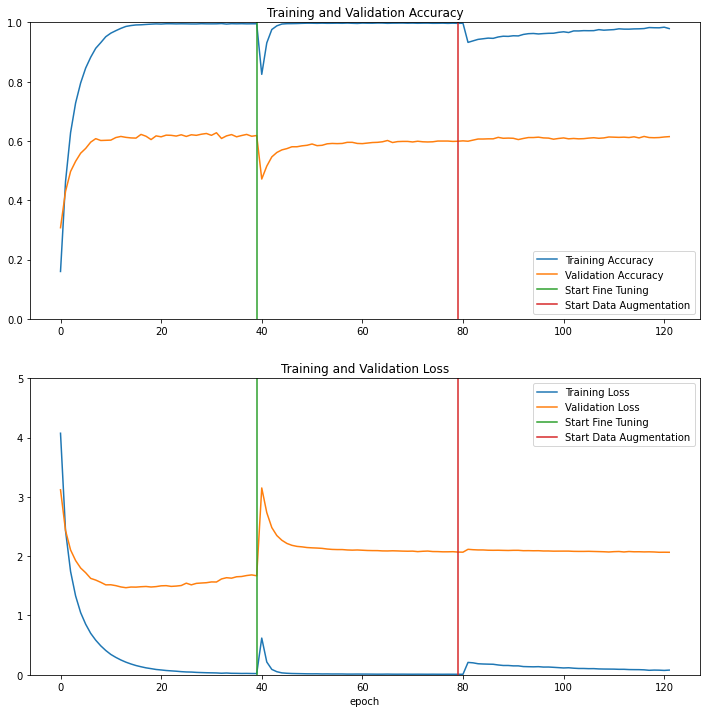

In [22]:
acc += history_aug.history['accuracy']
val_acc += history_aug.history['val_accuracy']

loss += history_aug.history['loss']
val_loss += history_aug.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.plot([total_epochs-1,total_epochs-1],
plt.ylim(), label='Start Data Augmentation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.plot([total_epochs-1,total_epochs-1],
plt.ylim(), label='Start Data Augmentation')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### 23. Compute Precision and Recall

In [23]:
y_pred = model.predict_classes(test_batches)

test_cnt = 0
y_pred_name = [0]*2000
y_label = [0]*2000
for image, label in test.take(1608):
  y_pred_name[test_cnt] = get_label_name(y_pred[test_cnt])
  y_label[test_cnt]     = get_label_name(label)
  test_cnt += 1

# precision = tp / (tp + fp)
precision = precision_score(y_label,y_pred_name,average='macro',zero_division=0)
print("Precision:")
print(precision)

# recall = tp / (tp + fn)
recall = recall_score(y_label,y_pred_name,average='macro')
print("Recall:")
print(recall)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Precision:
0.6108938161304539
Recall:
0.6047678843998641
